# Project 3 - Ames Housing Dataset Challenge <br>
## Thomas Brewer - BOS

In [27]:
# Import libraries

# Basic
import numpy as np
import pandas as pd

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# sklearn
from sklearn.preprocessing import StandardScaler, Imputer
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.feature_selection import RFECV, SelectKBest


# My own cleaning libraryb
import cleaning_tools as ct
import tools

# For reloading my tools, while working on them
from importlib import reload

import warnings
warnings.filterwarnings('ignore')

In [542]:
# Load data
reload(ct)
reload(tools)

def load_clean():
    data = tools.load_data('../data/train.csv')
    data = ct.basic_clean(data)
    data = ct.reshape_data(data)
    return data
data = load_clean()
test_data = tools.load_data('../data/test.csv')
test_data = ct.basic_clean(test_data, final=True)
test_data = ct.reshape_data(test_data)

### EDA : Familiarizing Myself With the Data so I can Organize it

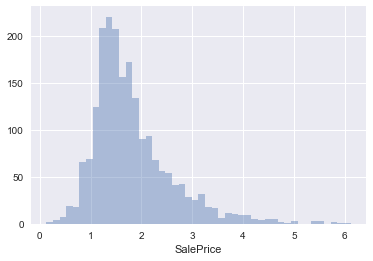

In [139]:
sns.distplot(data['SalePrice'], kde=False)

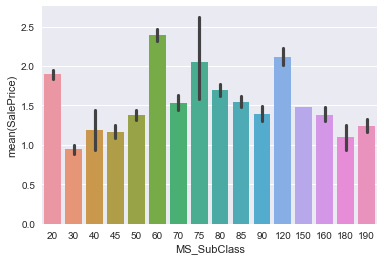

In [62]:
sns.barplot(x='MS_SubClass', y='SalePrice',data=data)

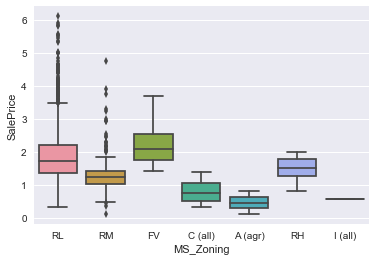

In [64]:
sns.boxplot(x='MS_Zoning', y='SalePrice', data=data)

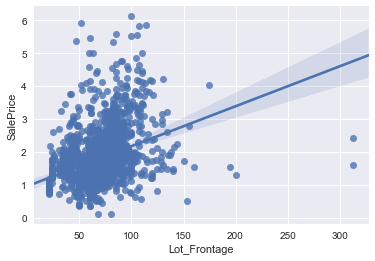

In [65]:
sns.regplot(x='Lot_Frontage', y='SalePrice', data=data)

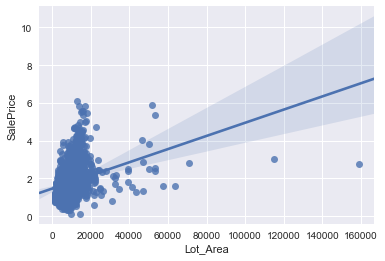

In [69]:
sns.regplot(x='Lot_Area', y='SalePrice', data=data)

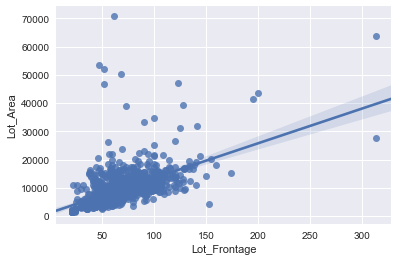

In [70]:
sns.regplot(x='Lot_Frontage', y='Lot_Area', data=data)

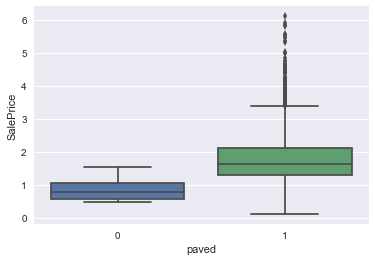

In [89]:
sns.boxplot(x='paved', y='SalePrice', data=data)

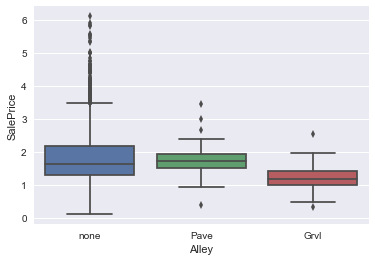

In [92]:
data['Alley'].fillna('none', inplace=True)
sns.boxplot(x='Alley', y='SalePrice', data=data)

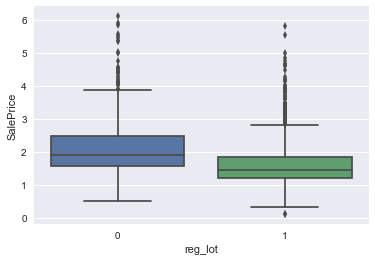

In [96]:
sns.boxplot(x='reg_lot', y='SalePrice', data=data)

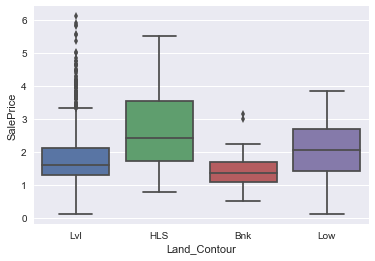

In [97]:
sns.boxplot(x='Land_Contour', y='SalePrice', data=data)

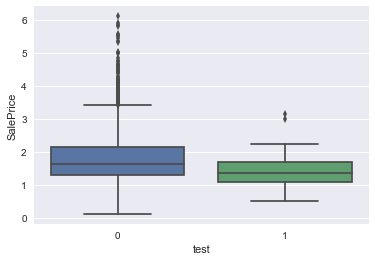

In [104]:
reload(ct)
data = load_clean()
sns.boxplot(x='test', y='SalePrice', data=data)

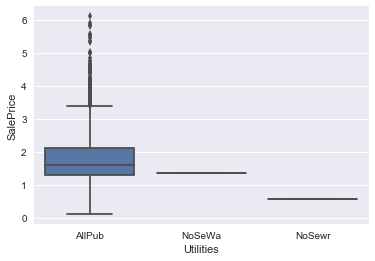

In [105]:
sns.boxplot(x='Utilities', y='SalePrice', data=data)

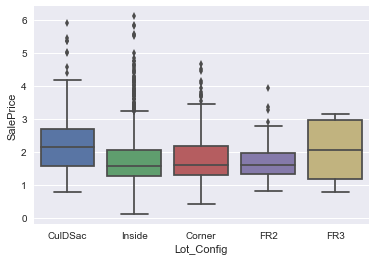

In [106]:
sns.boxplot(x='Lot_Config', y='SalePrice', data=data)

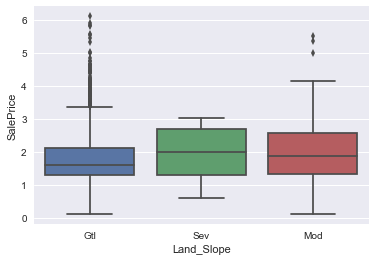

In [107]:
sns.boxplot(x='Land_Slope', y='SalePrice', data=data)

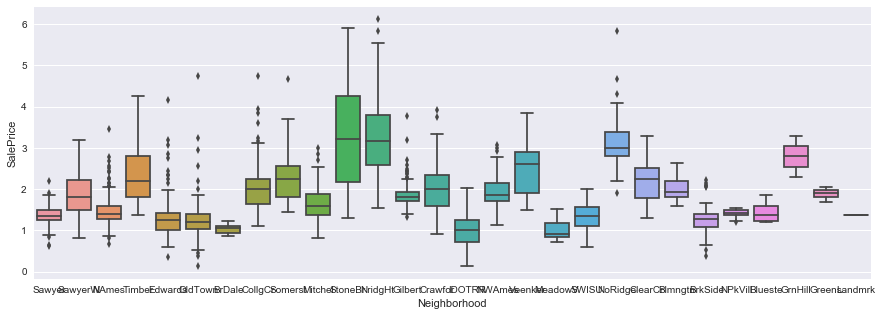

In [110]:
f, ax = plt.subplots(figsize=(15,5))
sns.boxplot(x='Neighborhood', y='SalePrice', data=data, ax=ax)

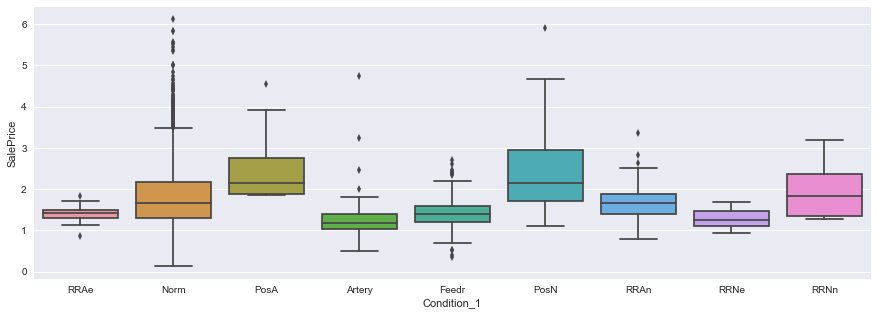

In [112]:
f, ax = plt.subplots(figsize=(15,5))
sns.boxplot(x='Condition_1', y='SalePrice', data=data, ax=ax)

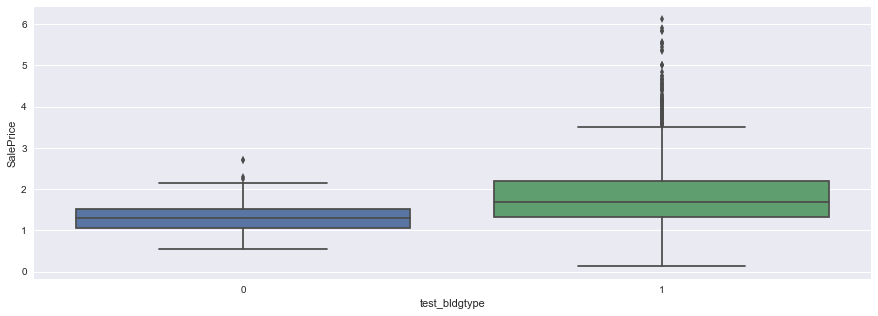

In [119]:
reload(ct)
data = load_clean()
f, ax = plt.subplots(figsize=(15,5))
sns.boxplot(x='test_bldgtype', y='SalePrice', data=data, ax=ax)

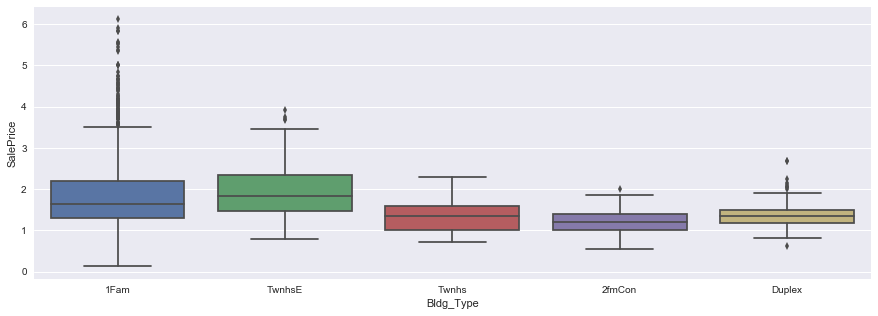

In [118]:
reload(ct)
data = load_clean()
f, ax = plt.subplots(figsize=(15,5))
sns.boxplot(x='Bldg_Type', y='SalePrice', data=data, ax=ax)

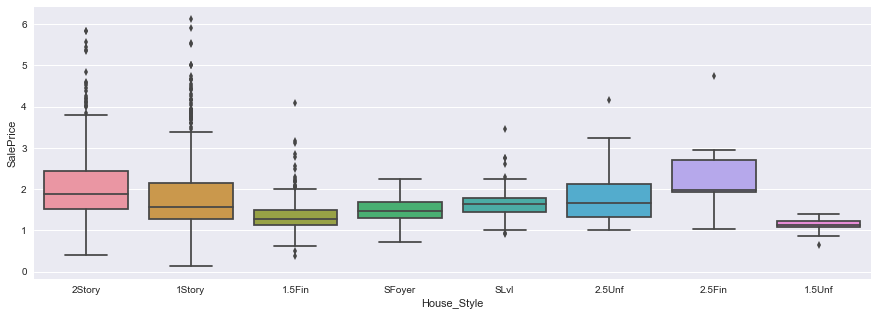

In [121]:
reload(ct)
data = load_clean()
f, ax = plt.subplots(figsize=(15,5))
sns.boxplot(x='House_Style', y='SalePrice', data=data, ax=ax)

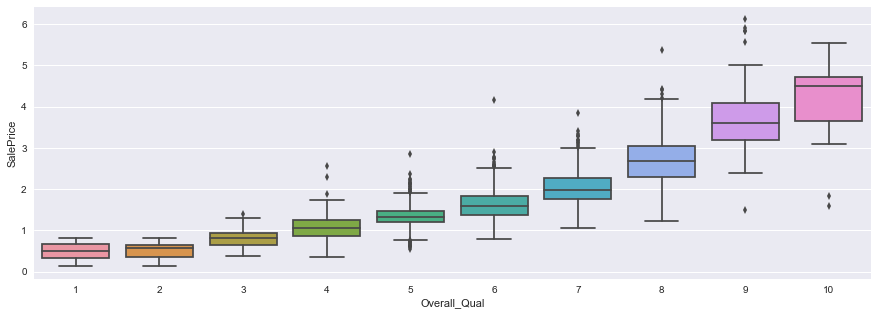

In [122]:
reload(ct)
data = load_clean()
f, ax = plt.subplots(figsize=(15,5))
sns.boxplot(x='Overall_Qual', y='SalePrice', data=data, ax=ax)

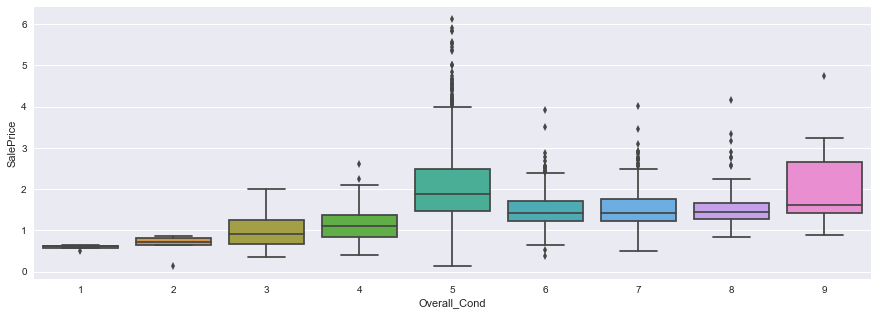

In [123]:
reload(ct)
data = load_clean()
f, ax = plt.subplots(figsize=(15,5))
sns.boxplot(x='Overall_Cond', y='SalePrice', data=data, ax=ax)

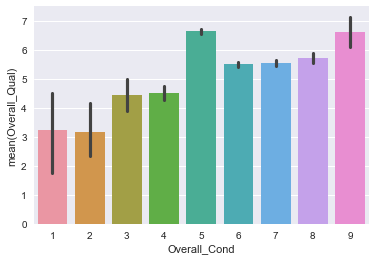

In [543]:
sns.barplot(x='Overall_Cond', y='Overall_Qual', data=data)

In [ ]:
data.

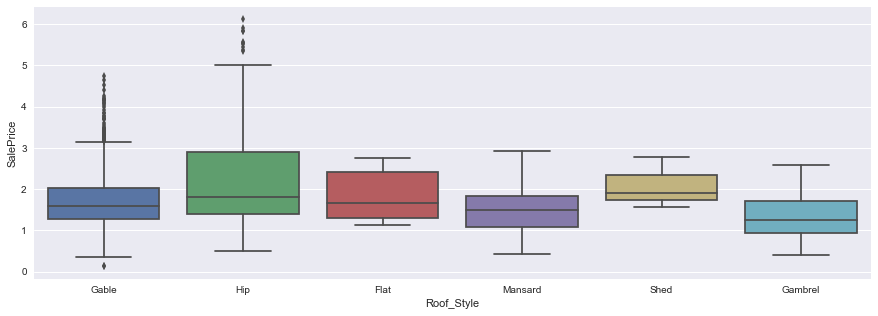

In [131]:
reload(ct)
data = load_clean()
f, ax = plt.subplots(figsize=(15,5))
sns.boxplot(x='Roof_Style', y='SalePrice', data=data, ax=ax)

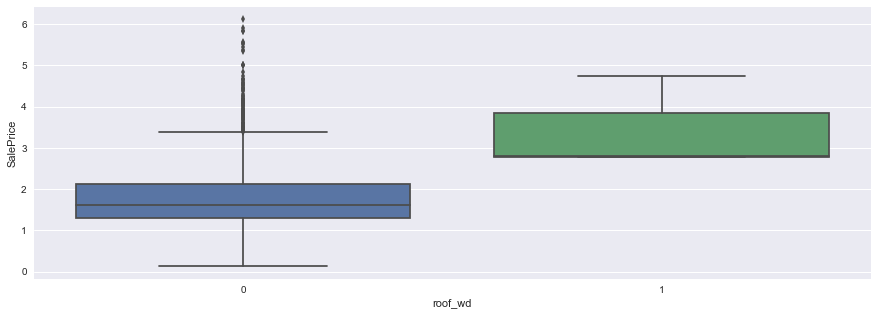

In [136]:
reload(ct)
data = load_clean()
f, ax = plt.subplots(figsize=(15,5))
sns.boxplot(x='roof_wd', y='SalePrice', data=data, ax=ax)

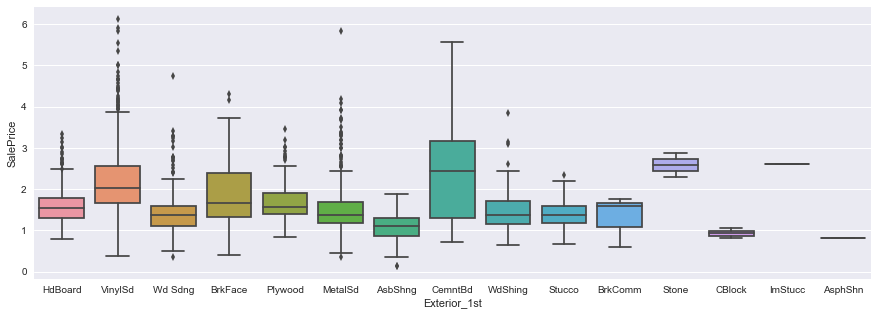

In [140]:
reload(ct)
data = load_clean()
f, ax = plt.subplots(figsize=(15,5))
sns.boxplot(x='Exterior_1st', y='SalePrice', data=data, ax=ax)

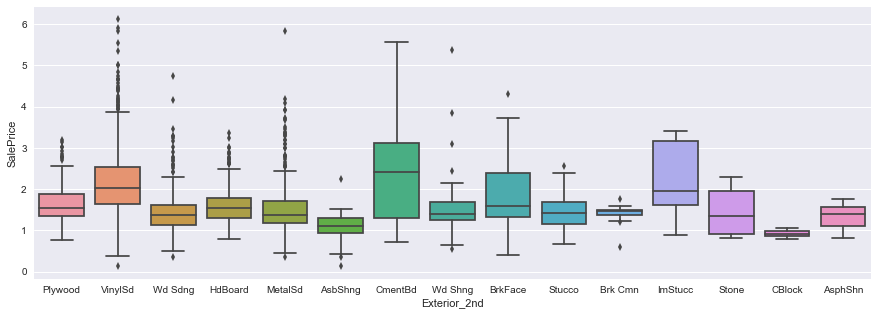

In [177]:
reload(ct)
data = load_clean()
f, ax = plt.subplots(figsize=(15,5))
sns.boxplot(x='Exterior_2nd', y='SalePrice', data=data, ax=ax)

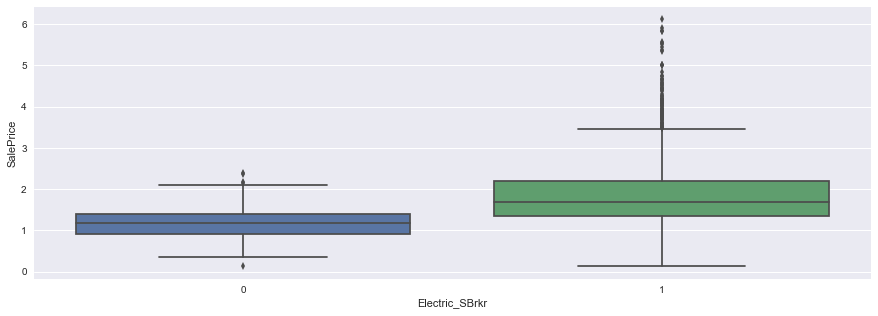

In [185]:
reload(ct)
data = load_clean()
f, ax = plt.subplots(figsize=(15,5))
sns.boxplot(x='Electric_SBrkr', y='SalePrice', data=data, ax=ax)

### Preprocessing - Outliers

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd42475a1d0>]], dtype=object)

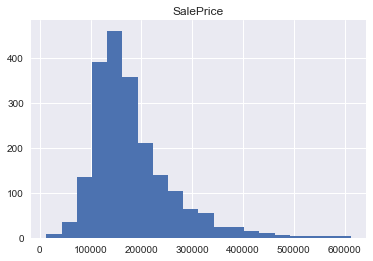

In [544]:
data.hist('SalePrice', bins=20)

In [352]:
data = data[data.Saleprice < 4]

Lot_Frontage 330
Mas_Vnr_Area 22
BsmtFin_SF_1 1
Bsmt_Unf_SF 1
Total_Bsmt_SF 1
Garage_Area 1


## EDA : Looking at Correlations

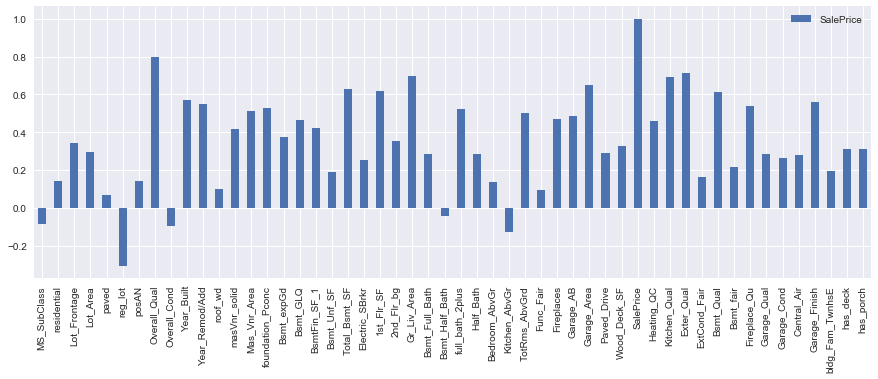

In [359]:
reload(tools)
tools.corr_bar(data)

In [548]:
reload(ct)
data_copy = data.copy()
keep = ct.corr_columns(data_copy, corr_val=0.1)    
X = data_copy[[c for c in keep if c!='SalePrice']].copy()
y = data_copy['SalePrice'].copy().values.reshape(-1,1)

# Split data into training and splitting
X, X_test, y, y_test = train_test_split(X, y, test_size=0.2)


# Clean training data :
# - Imputing for null values
# - Scaling with Standard Scaler
X, imputers, scalers = ct.train_clean(X)

# Use imputers and scalers on testing set:
ct.impute_columns(X_test, imputers)
ct.scale_columns(X_test, scalers)

# final testing set:
ct.impute_columns(test_data, imputers)
ct.scale_columns(test_data, scalers)

## Baseline -- Predict the Average Sale Price

In [488]:
baseline = data['SalePrice'].mean()
print(baseline*100000)

181469.701608971


## SelectKBest

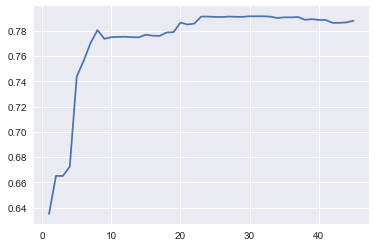

In [555]:
lr = Ridge(alpha=75)
scores = []
ks = [i for i in range(1, X.shape[1]+1)]
for k in ks:
    _ = SelectKBest(k=k).fit_transform(X,y)
    cvs = cross_val_score(lr, _, y, cv=5)
    scores.append(cvs.mean())
    
plt.plot(ks, scores)

In [556]:
sel = SelectKBest(k=25).fit(X, y)

best alpha :  182.454545455


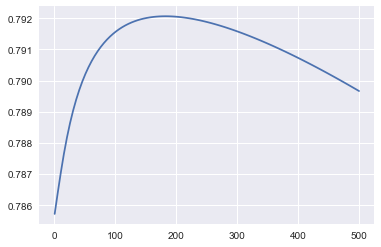

In [557]:
scores = []
alpha = np.linspace(1, 500, num=100)
for a in alpha:
    r = Ridge(alpha=a)
    cvs = cross_val_score(r, sel.transform(X), y, cv=5)
    scores.append(cvs.mean())

plt.plot(alpha, scores)
print('best alpha : ', alpha[scores.index(max(scores))])

## Basic Linear Regression Model

In [558]:
lr = LinearRegression(n_jobs=-1)
print(cross_val_score(lr, X, y, cv=5).mean())
lr.fit(sel.transform(X),y)
lr.score(sel.transform(X_test), y_test)

0.779670613057


0.86268762259695264

## Ridge Regularization

In [559]:
# alpha = [i*0.1 for i in range(1, 11)]
# for a in alpha:

r = Ridge(alpha=182)
print('train',cross_val_score(r, sel.transform(X), y, cv=5).mean())
r.fit(sel.transform(X),y)
print('test',r.score(sel.transform(X_test), y_test))

train 0.792067374671
test 0.85981440813


In [475]:
r.coef_

array([[-0.00043372,  0.01148121,  0.0416209 , -0.01586517,  0.01013174,
         0.12478662,  0.00148231,  0.00178283, -0.02342246,  0.00042331,
         0.02160694,  0.0645485 ,  0.02496878,  0.02601378, -0.01611718,
         0.03265256, -0.01269875,  0.05559516,  0.05937908,  0.09326079,
         0.04289015, -0.01085828,  0.00647448, -0.00329764, -0.01965563,
         0.04483856,  0.00761155,  0.00874383,  0.07854437,  0.00460819,
         0.01805679,  0.02602933,  0.09357412,  0.08462503,  0.00405224,
         0.0472815 , -0.01197297,  0.0392965 , -0.00347788, -0.01903484,
        -0.00133235,  0.01031753,  0.03718064, -0.01325719,  0.00490237]])

## Lasso Regularization

In [427]:
l = Lasso()
print(cross_val_score(l, X, y, cv=5))
l.fit(X,y)
l.score(X_test.values, y_test)

[ 0.46318617  0.51073998  0.53977299  0.46222416  0.45349171]


0.52508504279506041

### 

## Final Test Data

In [520]:
print(test_data.shape)
print(test_X.shape)

(879, 51)
(879, 45)


In [570]:
predictions.shape

(879,)

In [576]:
ids = test_data['Id'].copy()
test_copy = test_data.copy()
test_X = test_copy[[c for c in keep if c != 'SalePrice']]
test_X.shape
predictions = pd.DataFrame(r.predict(sel.transform(test_X)).flatten())

final_table = pd.concat([ids, predictions], axis=1)
#save file :
final_table.to_csv('final_table.csv', header=['Id', 'SalePrice'], index=False)



In [577]:
predictions.mean()

0    101789.9985
dtype: float64

## EDA

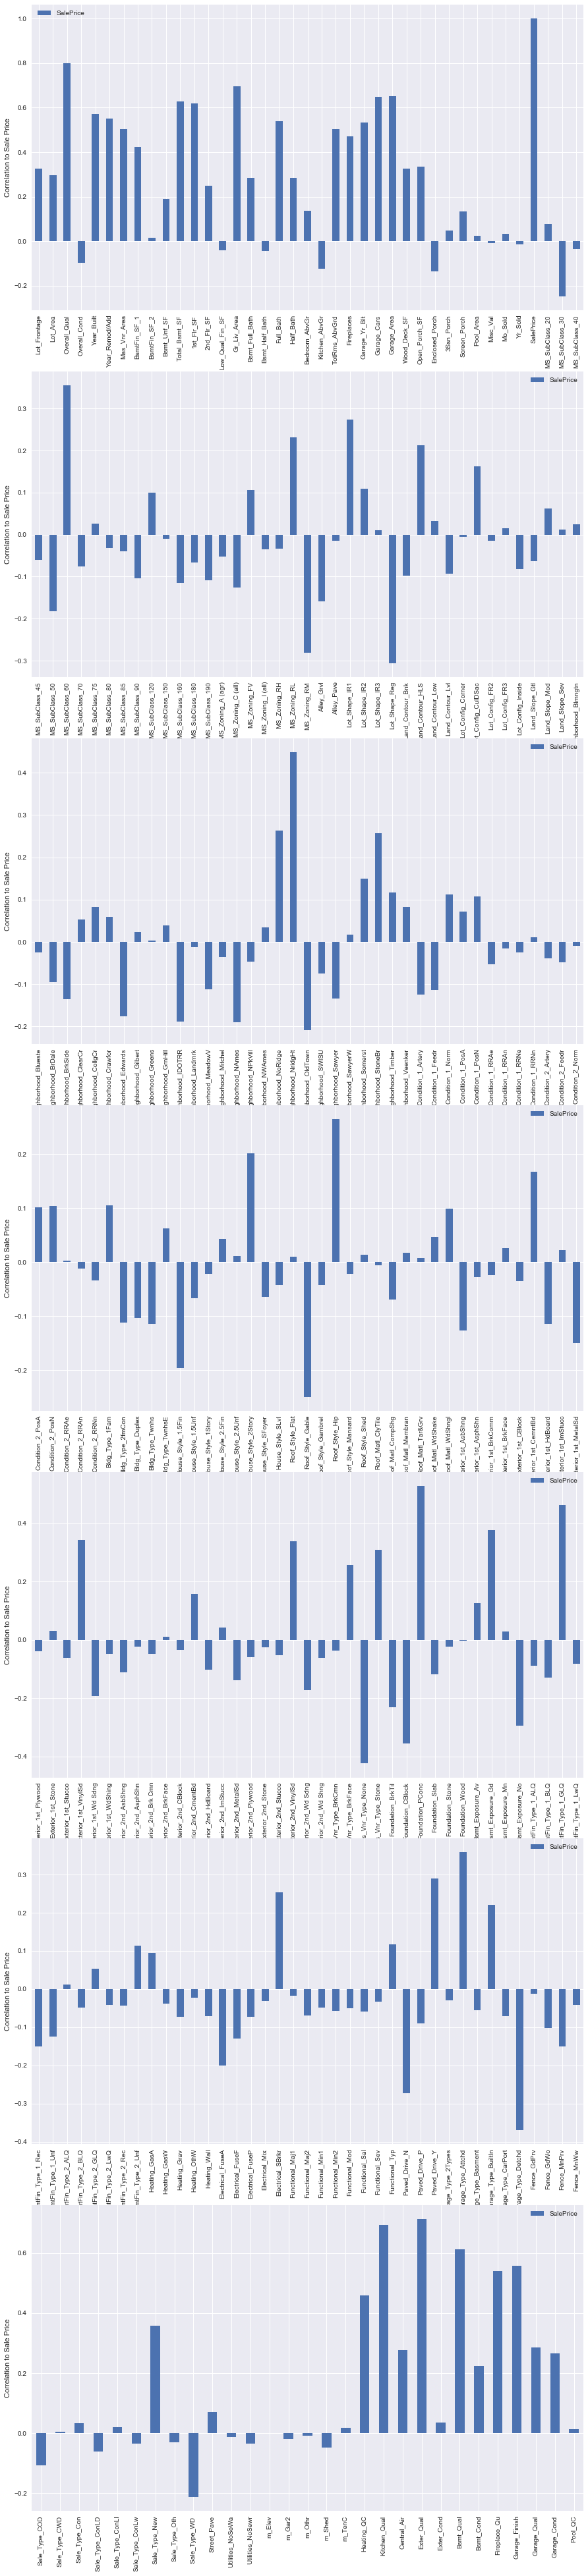

In [243]:
# Barplot of feature correlations to SalePrice
# predictors = [c for c in data.columns if c not in ['SalePrice', 'Id', 'PID']]

corr = data.corr()

features_per_plot = 39
nplots = 7
f, grid = plt.subplots(nrows=7, ncols=1, figsize=(15,10*nplots))

for i in range(nplots):
    ni = i*features_per_plot
    nf = (i + 1)*features_per_plot
    corr[ni:nf].plot(x = corr.columns[ni:nf], y='SalePrice', kind='bar', ax=grid[i])
    grid[i].set_ylabel('Correlation to Sale Price')
    grid[i].legend()

## Picking Features

In [244]:
#### Eliminate anything that doesn't have a correlation
# above 0.4
del_cols = [c for c in corr.columns if (abs(corr['SalePrice'][c]) < 0.4)]
for c in del_cols:
    data.drop(c, inplace=True, axis=1)

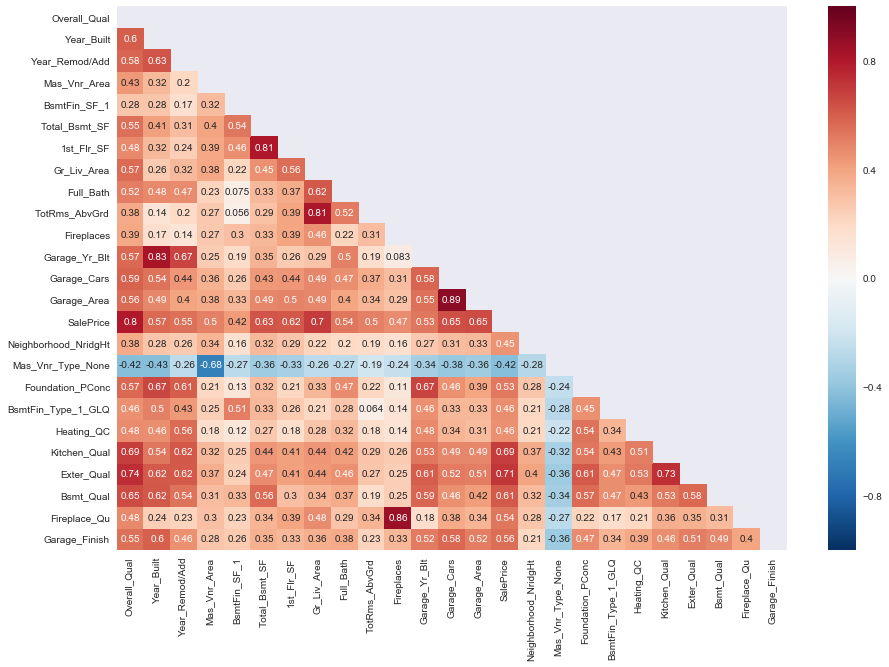

In [218]:
corr_mat = data.corr()

mask = np.zeros_like(corr_mat)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(15,10))
sns.heatmap(corr_mat, fmt='.2g', annot=True, mask=mask)

In [219]:
data.shape

(2051, 26)

Seems like a lot of these are also correlated to each other.

In [283]:
reload(ct)
data = ct.make_clean(corr_val=0.4)

/home/thomas/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


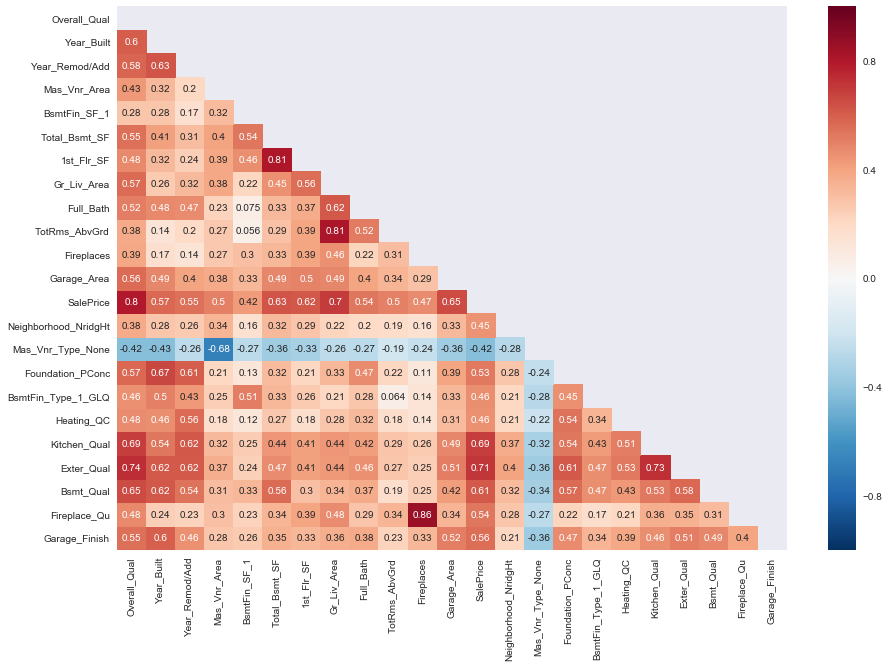

In [284]:
tools.corr_map(data)

In [285]:
reload(ct)
reload(tools)
data = ct.make_clean()
X = data[[c for c in data.columns if c != 'SalePrice']]
y = data[['SalePrice']]

/home/thomas/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


In [274]:
X.isnull().sum()

Overall_Qual            0
Year_Built              0
Year_Remod/Add          0
Mas_Vnr_Area            0
BsmtFin_SF_1            0
Total_Bsmt_SF           0
1st_Flr_SF              0
Gr_Liv_Area             0
Full_Bath               0
TotRms_AbvGrd           0
Fireplaces              0
Garage_Area             0
Neighborhood_NridgHt    0
Mas_Vnr_Type_None       0
Foundation_PConc        0
BsmtFin_Type_1_GLQ      0
Heating_QC              0
Kitchen_Qual            0
Exter_Qual              0
Bsmt_Qual               0
Fireplace_Qu            0
Garage_Finish           0
dtype: int64

In [438]:
lr = LinearRegression()
rfecv = RFECV(lr, step=1, n_jobs=-1)
rfecv.fit(X.values,y)

RFECV(cv=None,
   estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False),
   n_jobs=-1, scoring=None, step=1, verbose=0)

In [439]:
X2 = rfecv.transform(X)

In [440]:
rfecv.score(X,y)

0.84150494768476258